### EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('telecom_users.csv')
df.drop(columns=['Unnamed: 0', 'customerID'], inplace=True) 

print(df.shape) 
df.head(3)

(5986, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


`telecom_users.csv` :<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `customerID` – id клиента<br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` – пол клиента (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` – яляется ли клиент пенсионером (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – состоит ли клиент в браке (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` – есть ли у клиента иждивенцы (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – сколько месяцев человек являлся клиентом компании<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – подключена ли услуга телефонной связи (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – подключены ли несколько телефонных линий (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – интернет-провайдер клиента (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – подключена ли услуга онлайн-безопасности (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – подключена ли услуга online backup (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – есть ли у клиента страховка оборудования (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` – подключена ли услуга технической поддержки (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – подключена ли услуга стримингового телевидения (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – подключена ли услуга стримингового кинотеатра (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – тип контракта клиента (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – пользуется ли клиент безбумажным биллингом (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – метод оплаты (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges` – месячный размер оплаты на настоящий момент<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` – общая сумма, которую клиент заплатил за услуги за все время<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` – произошел ли отток (Yes or No)<br>

In [4]:
##  TotalCharges в numeric # TotalCharges   5986 non-null   object
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print('пропуски в TotalCharge = ' , df['TotalCharges'].isna().sum())


## Замена Yes и No в Churn на 1 и 0 (1 == Churn)
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else np.nan))
print('пропуски в Churn = ' , df['Churn'].isna().sum())

пропуски в TotalCharge =  10
пропуски в Churn =  0


In [5]:
## замена на 1, 2, 3 соответственно периоду

df['Contract'] = df['Contract'].apply(lambda x: 1 if x == 'Month-to-month' else (2 if x == 'One year' else 3))

In [6]:
## Посмотрим  можно ли заполнить пропуски со смыслом, нет, значения рядом слишком разные

nan_index = df['TotalCharges'][df['TotalCharges'].isna()].index
nan_index = sorted(nan_index.to_list() + (nan_index + 1).to_list() + (nan_index -1).to_list())
df['TotalCharges'][nan_index]

355      237.95
356         NaN
357      521.35
633     3339.05
634         NaN
635     3778.85
2770      44.00
2771        NaN
2772     475.20
3085    3069.45
3086        NaN
3087      39.25
3254     155.35
3255        NaN
3256     475.10
4325     442.60
4326        NaN
4327      35.85
5374     467.15
5375        NaN
5376    1992.95
5381    3186.65
5382        NaN
5383     973.10
5694     439.20
5695        NaN
5696    1415.85
5950     678.20
5951        NaN
5952      74.70
Name: TotalCharges, dtype: float64

In [7]:
## поэтому просто удалим эти строки, тем более их очень мало, всего 10 << 5986

df.dropna(inplace=True) # (5976, 20)
df.reset_index(inplace=True, drop=True)

In [8]:
## Categorical Columns

obj_columns_list = [i for i in df.columns if df[i].dtype == 'object']
df[obj_columns_list].nunique().unique() # порядок уникальных значений в категориальных колонках

array([2, 3, 4], dtype=int64)

In [9]:
## Number Columns

number_columns_list = df.select_dtypes(include=np.number).columns
print(df[number_columns_list].apply(lambda x: x.unique().size)) # сколько уникальных значений в колонке
#number_columns_list = number_columns_list.delete([0, 2, 4]) # удалим SeniorCitizen, Contract и Churn

SeniorCitizen        2
tenure              72
Contract             3
MonthlyCharges    1525
TotalCharges      5610
Churn                2
dtype: int64


In [10]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].apply({'count', 'min', 'max', 'mean', 'median', 'std'}).T

,max,count,std,median,min,mean
tenure,72.00,5976.0,24.500858,29.000,1.00,32.523092
MonthlyCharges,118.75,5976.0,30.107576,70.425,18.25,64.846687
TotalCharges,8684.80,5976.0,2274.127165,1412.150,18.80,2298.060617


смотрим распределения

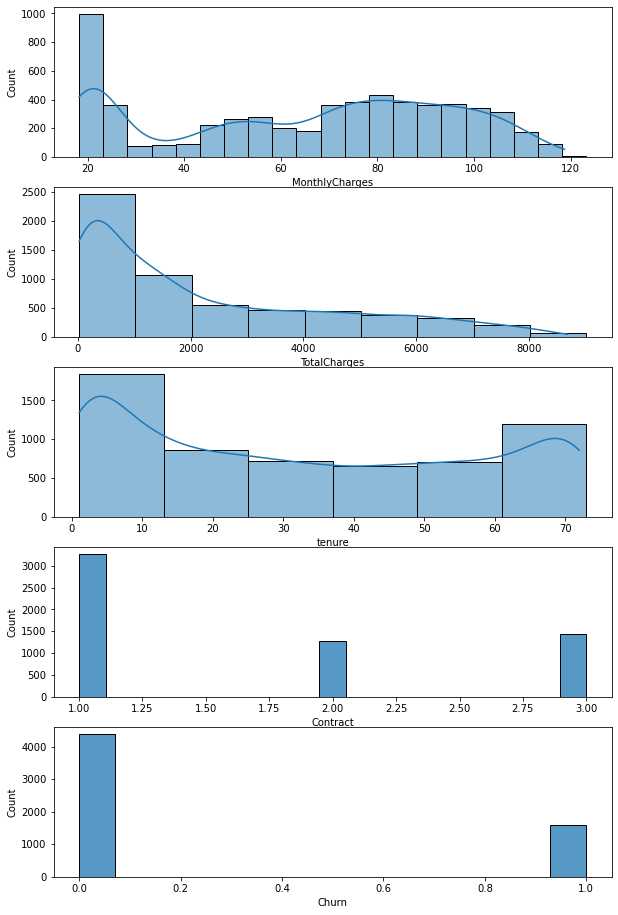

In [11]:
fig, axis = plt.subplots(5,1, figsize=(10,16))
sns.histplot(df['MonthlyCharges'], ax=axis[0], kde=True, binwidth=5)
sns.histplot(df['TotalCharges'], ax=axis[1], kde=True, binwidth=1000)
sns.histplot(df['tenure'], ax=axis[2], kde=True, binwidth=12)
sns.histplot(df['Contract'], ax=axis[3])
sns.histplot(df['Churn'], ax=axis[4], binrange=(0,1))
plt.show()
#df.hist(['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract', 'Churn'], bins=14, figsize=(16,8), grid=False);

In [12]:
# т.к данные не сбалансированные, то далее используем StratifiedKFold

print('Соотношение 0 к 1 = ', (df.shape[0] - df.Churn.sum()) / df.Churn.sum())

Соотношение 0 к 1 =  2.765595463137996


In [13]:
df1 = pd.get_dummies(df) # == OneHotEncoder for Categorical Columns
df1.head(3) # (5976, 46)

,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,72,3,24.10,1734.65,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0
1,0,44,1,88.15,3973.20,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0
2,1,38,1,74.95,2869.85,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0


In [14]:
qaz = df1.columns.tolist() # переставим местами
qaz = qaz[6:] + qaz[:6]
df1 = df1[qaz] # (5976, 44)

In [15]:
# на удаление, т.к. дублируются или корреляция = 1

bad = ['gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No', 'MultipleLines_No', \
       'MultipleLines_No phone service', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', \
       'OnlineBackup_No', 'OnlineBackup_No internet service', \
       'DeviceProtection_No', 'DeviceProtection_No internet service', \
       'TechSupport_No',  'TechSupport_No internet service', \
       'StreamingTV_No',  'StreamingTV_No internet service', \
       'StreamingMovies_No', 'StreamingMovies_No internet service', \
       'PaperlessBilling_No',]

In [16]:
good = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
        'gender_Male', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes',
        'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
        'StreamingMovies_Yes', 
        'Contract',
        'PaperlessBilling_Yes',
        'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [17]:
df1.drop(bad, axis=1, inplace=True, errors='ignore') # (5976, 25)

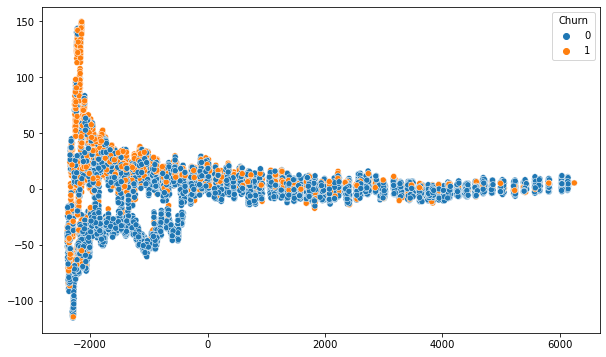

In [18]:
## Отобразим распределение клиентов - все очень перемешано

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=17, init='pca')
qaz = tsne.fit_transform(df1.drop(columns='Churn'))

fig, axis = plt.subplots(figsize=(10,6))
sns.scatterplot(x=qaz[:, 0], y=qaz[:, 1], hue=df1['Churn']);

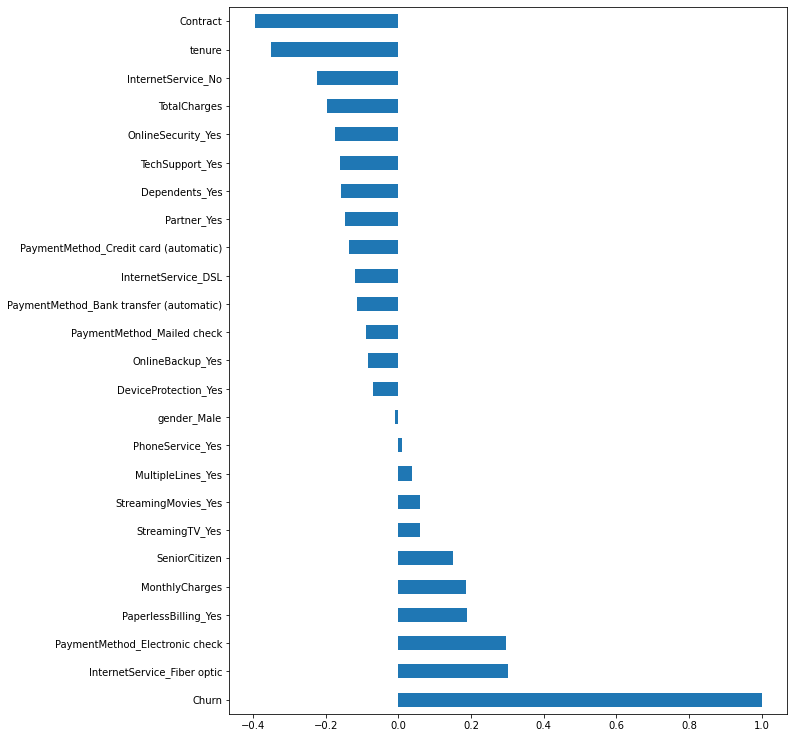

In [19]:
## Влияние фичей на отток

df1.corr()['Churn'].sort_values(ascending = False).plot(kind='barh', figsize=(10,13));

In [20]:
## Преобразование данных np.log

cols_to_scale = ['tenure', 'TotalCharges', 'MonthlyCharges']
df1[cols_to_scale] = df1[cols_to_scale].apply(np.log)

In [21]:
## данные для обучения\проверки

X = df1.drop(['Churn'], axis=1)
y = df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=17)

###  Модели для прогнозирования оттока

In [22]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [23]:
# алгоритмы

gbc = GradientBoostingClassifier(random_state=17)
lr = LogisticRegression(random_state=17, max_iter=10000)
rfc = RandomForestClassifier(random_state=17, class_weight= "balanced")
abc = AdaBoostClassifier(random_state=17)
dtc = DecisionTreeClassifier(random_state=17, class_weight="balanced")

skf = StratifiedKFold(shuffle=True, random_state=17)

In [24]:
# параметры алгоритмов

gbc_params = {'learning_rate':np.arange(0.1, 0.6, 0.1), 'n_estimators':range(10,50,10)} #GradientBoostingClassifier
lr_params = {'C': np.arange(0.1, 1.1, 0.1)} #LogisticRegression
rfc_params = {'n_estimators':range(10,50,10), 'min_samples_leaf':range(1, 5), 'max_depth':[3,4,5,6,7]}#RandomForestCl
abc_params = {'learning_rate':np.arange(0.1, 0.6, 0.1), 'n_estimators':range(10,50,10)} #AdaBoostClassifier
dtc_params = {'max_depth':[3,4,5,6]} #DecisionTreeClassifier

models_params = [gbc_params ,lr_params, rfc_params, abc_params, dtc_params]
models = [gbc ,lr, rfc, abc, dtc]

### Сравнение качества моделей 

In [25]:
## это как самый базовый алгоритм

from sklearn.naive_bayes import GaussianNB

gnb= GaussianNB()
gnb.fit(X_train, y_train)
print('roc_auc_score = ', roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]))

roc_auc_score =  0.8236941104212052


In [26]:
## GridSearchCV for models

score_matrix = []
for i, model in enumerate(models):
    gs_cv = GridSearchCV(model, models_params[i], cv=skf)
    models[i] = gs_cv.fit(X_train, y_train).best_estimator_
    score = roc_auc_score(y_test, models[i].predict_proba(X_test)[:, 1])
    score_matrix.append(score)
    print(models[i])
    print('   roc_auc_score = ', score, '\n')
    
print('MAX_roc_auc_score = ', max(score_matrix))

GradientBoostingClassifier(learning_rate=0.2, n_estimators=40, random_state=17)
   roc_auc_score =  0.8366754317776861 

LogisticRegression(C=0.1, max_iter=10000, random_state=17)
   roc_auc_score =  0.8385340191872758 

RandomForestClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=3,
                       n_estimators=40, random_state=17)
   roc_auc_score =  0.8307109976551728 

AdaBoostClassifier(learning_rate=0.4, n_estimators=40, random_state=17)
   roc_auc_score =  0.8360180484512305 

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=17)
   roc_auc_score =  0.8086286759883943 

MAX_roc_auc_score =  0.8385340191872758


In [27]:
## StackingClassifier со всеми обученными моделями

from sklearn.ensemble import StackingClassifier

estimators = models.copy()
estimators = [('gbc', estimators[0]), ('lr', estimators[1]), ('rfc', estimators[2]), \
             ('abc', estimators[3]), ('dtc', estimators[4])]

stack = StackingClassifier(estimators=estimators, cv=skf)
stack.fit(X_train, y_train)
print('roc_auc_score = ', roc_auc_score(y_test, stack.predict_proba(X_test)[:, 1]))

roc_auc_score =  0.8375695370805782


### Итоги

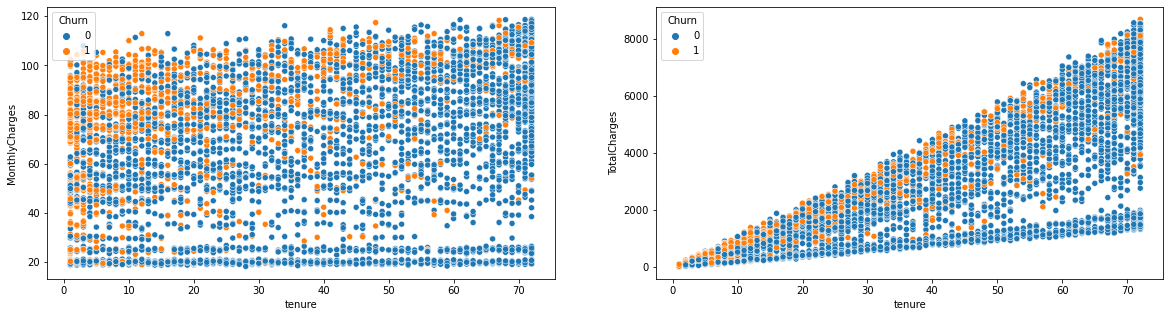

In [28]:
## расперделение оттока по времени и платежу

fig, axis = plt.subplots(1,2, figsize=(20,5))
sns.scatterplot(data=df, x="tenure", y="MonthlyCharges", hue="Churn", ax=axis[0])
sns.scatterplot(data=df, x="tenure", y="TotalCharges", hue="Churn", ax=axis[1]);

Достаточно одинаковое количество пользователей, пользующихся услугой разное количество времени, кроме вполне естественного большого количества в начале, проблемы:
- большой отток на старте, примерно в течении года, возможно это связано с переходом клиентов с помесячного контракта на более длительные, но выяснить это более точно нельзя, т.к количество уникальных customerID = 5986 = df.shape[0], т.е. при таких переходах заключался новый контракт
- основной отток клиентов происходит среди тех, чей тариф от 30 до 50, причем те кто платит 30 однозначно в итоге уходят, подтверждение - пробелы на TotalCharges после 50 мес
- изначально очень мало клиентов на тарифе 30-35-40

### Kaplan Meier curve

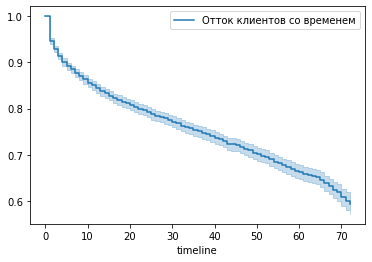

In [29]:
## Посмотрим Kaplan Meier curve

#pip install lifelines
from lifelines import KaplanMeierFitter

durations = df['tenure'] ## Время в мес
event_observed = df['Churn']  ## Был отток или нет

km = KaplanMeierFitter()
km.fit(durations, event_observed, label='Отток клиентов со временем')
km.plot();

40 процентов всех изначальных клиентов уйдет за рассмастриваемый период (6 лет)

### The best Model

т.к. монотонные преобразования входных данных не влияют на качество работы моделй, основанных на алгоритмах, использующих "деревья", но данное преобразование позволяет повысить итоговую метрику при использовании LogisticRegression, а также, то что StackingClassifier не оказал положительного влияния на результат, то используем ее с параметрами - LogisticRegression(C=0.1, max_iter=10000, random_state=17)

In [30]:
lr = LogisticRegression(C=0.1, max_iter=10000, random_state=17).fit(X_train, y_train)

print('roc_auc_score = ', roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

roc_auc_score =  0.8385340191872758
